In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
env = gym.make('MountainCarContinuous-v0')

### MLP

In [4]:
class GaussMLP(nn.Module):
    def __init__(self, obs_space, action_space):
        super(GaussMLP, self).__init__()
        
        self.input_dim = obs_space
        self.action_space = action_space
        
        #Layers
        self.linear1 = torch.nn.Linear(obs_space, 128)
        self.linear2 = torch.nn.Linear(128, 256)
        
        self.muLinear = torch.nn.Linear(256,action_space)
        self.logStdLinear = torch.nn.Linear(256,action_space)
    
    def forward(self, x):
        #Common input
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        #MuNet
        mu = self.muLinear(x)
        log_std = self.logStdLinear(x)
        
        return mu, log_std
           

In [5]:
input1 = torch.randn((10,2))
input1

tensor([[ 0.4412,  0.1922],
        [ 0.9539,  0.3484],
        [-0.0834,  0.9530],
        [ 0.1663,  1.1800],
        [ 0.1653, -0.3139],
        [-0.1116, -0.1772],
        [ 1.3367,  1.9263],
        [ 0.3057, -1.3336],
        [-0.7902, -0.5900],
        [-0.4282, -0.5596]])

In [6]:
gaussMLP = GaussMLP(2,1)

In [7]:
mu, log_std = gaussMLP(input1)
mu

tensor([[-0.0315],
        [-0.0855],
        [ 0.0318],
        [ 0.0172],
        [-0.0530],
        [-0.0220],
        [-0.1026],
        [-0.1414],
        [-0.0075],
        [-0.0207]], grad_fn=<AddmmBackward>)

### Trainer, Rewards, gauss log likelihood

In [8]:
def gaussianLogLikelihood(x, mu, log_std):
    pre_sum = -1/2 * ((x-mu)/torch.exp(log_std))**2 + 2*log_std + torch.log(torch.tensor(2*np.pi))
    return pre_sum.sum(axis=-1)

In [392]:
def normalize_rewards(rewards):
    mu = np.mean(rewards)
    std = np.std(rewards)
    
    return (rewards-mu)/(std+1e-6)

def discount_rewards(rewards, gamma):
    d_rewards = np.zeros_like(rewards, dtype=np.float64)
    
    for t in range(len(rewards)):
        d_rewards[t] = (gamma**t) * rewards[t]
    d_rewards = normalize_rewards(d_rewards)
    return torch.tensor(d_rewards)
    

In [391]:
0.0002/np.std(np.array(d_rew), axis=-1)

1.544651047398199

In [318]:
d_rew = [-3.80876138e-04, -2.55172049e-04, -1.76183130e-07, -1.95032323e-05,
 -3.76102844e-04, -1.20451498e-06, -2.83300429e-04, -4.89308993e-04,
 -1.52103374e-04, -1.29847920e-04, -7.11397251e-04, -9.36299000e-04,
 -7.12085488e-04, -4.16906192e-04, -6.92270382e-04, -3.65681889e-04,
 -2.40162965e-04, -1.84573943e-04, -5.92723380e-05, -3.12355577e-04,
 -1.12618333e-05, -1.14278758e-04, -8.88052336e-05, -1.03291046e-04,
 -2.76301840e-05, -1.18257048e-06, -1.21504107e-04, -1.02630690e-04,
 -1.51748842e-04, -2.64475575e-05, -3.20362269e-05, -3.72069620e-05,
 -2.48220320e-05, -5.11084467e-05, -4.17585179e-05, -1.21570370e-04,
 -1.50230821e-05, -9.64014347e-05, -3.82670668e-05, -1.29841574e-04,
 -3.41215115e-05, -1.00005364e-04, -7.00088569e-06, -1.09368164e-06,
 -3.55779892e-05, -1.03984127e-04, -3.28086203e-05, -7.83308688e-05,
 -3.64640380e-05, -2.41459316e-05, -8.98708232e-07, -8.87275637e-06,
 -2.76688551e-05, -2.36091061e-05, -3.96708364e-05, -8.68119052e-05,
 -5.11073856e-05, -1.41074588e-05, -1.43060879e-06, -6.14162416e-06,
 -1.66270638e-05, -6.45662104e-06, -1.52275335e-05, -6.74033709e-05,
 -1.84811176e-05, -3.09074837e-05, -7.31031595e-07, -1.71989678e-05,
 -9.44437549e-06, -1.94030352e-05, -5.84446911e-05, -2.31086321e-05,
 -3.08877940e-06, -1.66409302e-05, -1.59766226e-05, -5.94554733e-07,
 -3.53709688e-06, -4.35943138e-05, -1.24747034e-05, -1.77521021e-05,
 -1.84887188e-05, -1.06331425e-05, -3.06585579e-06, -3.31253573e-06,
 -1.15710910e-05, -1.33792437e-05, -2.85573142e-06, -1.07056067e-05,
 -4.83043690e-06, -1.22011778e-06, -7.27009804e-06, -2.78697411e-06,
 -6.65437469e-06, -1.20916766e-06, -4.44649005e-06, -8.84388566e-06,
 -2.18707922e-06, -3.56037362e-08, -1.58468497e-06, -7.15606783e-06,
 -2.34671444e-06, -9.79331403e-07, -2.31919636e-06, -2.51330846e-06,
 -8.92218087e-07, -2.21506430e-06, -1.94580510e-06, -4.88790797e-06,
 -1.17963671e-06, -2.60056829e-07, -6.85560274e-07, -2.33801746e-06,
 -1.35549523e-08, -9.51865894e-07, -9.19696630e-07, -1.88705359e-07,
 -2.90842837e-09, -4.19925130e-08, -2.64673481e-07, -5.23325467e-07,
 -9.59461174e-07, -6.96411138e-07, -1.12269257e-06, -1.07157326e-09,
 -4.72117981e-08, -4.57577725e-07, -6.39935941e-07, -7.67476363e-07,
 -2.29397483e-07, -2.93319586e-07, -6.52371811e-07, -5.89728094e-07,
 -7.39881652e-07, -5.80502971e-07, -1.71052740e-07, -7.17298218e-07,
 -3.36245471e-07, -2.59163707e-07, -1.22851050e-07, -4.01869670e-10,
 -6.69508396e-07, -1.06476409e-07, -2.69198378e-07, -7.71781155e-08,
 -3.39530754e-07, -2.45293280e-07, -5.51882304e-07, -5.27220753e-07,
 -1.60118396e-07, -4.56171002e-07, -2.28316643e-08, -2.36868715e-07,
 -2.36907149e-07, -2.58170590e-07, -3.54953095e-07, -2.09969354e-08,
 -7.92220304e-08, -1.59368800e-07, -1.56108624e-07, -1.20473473e-07,
 -1.21506622e-07, -1.78752132e-07, -2.00846664e-07, -3.44351883e-07,
 -1.47342366e-08, -2.24488647e-07, -6.74569778e-08, -2.33253770e-08,
 -8.25518231e-08, -4.14692008e-10, -9.56563322e-08, -1.70281005e-07,
 -4.80558407e-08, -5.38276717e-08, -5.05984162e-09, -2.11685329e-08,
 -1.22187636e-07, -6.87727296e-08, -3.14563000e-08, -8.32641932e-10,
 -9.41432928e-09, -1.31706898e-07, -3.81441696e-08, -6.08778346e-09,
 -4.89637742e-08, -1.76753330e-09, -3.03889991e-08, -3.16064848e-08,
 -3.13840182e-10, -1.40831868e-08, -4.00253982e-08, -1.54339637e-09,
 -6.52011295e-09, -2.30261507e-08, -2.17966842e-09, -7.74603689e-09,
 -6.57346940e-09, -2.96727844e-08, -1.42063345e-08]

In [396]:
class GaussMLPTrainer():
    def __init__(self, gaussMLP, lr=1e-3, gamma=0.95):
        self.gaussMLP = gaussMLP
        self.optimizer = torch.optim.Adam(gaussMLP.parameters(), lr=lr)
        self.gamma = gamma
        
    def train_step(self, observations, actions, rewards):
        observations = torch.tensor(observations)
        actions = torch.tensor(actions)
        #rewards as tensor
        discounted_rewards = discount_rewards(rewards, self.gamma)
        
        #Correr el modelo
        mu, log_std = self.gaussMLP(observations) #size = (batch_size, action_space)
        #Calcular Loss
        loss = gaussianLogLikelihood(actions,mu,log_std)
        
        #Loss = RlogLikelihood
        loss = loss*discounted_rewards
        loss = loss.mean()
        
        loss.backward()
        #Optimizar
        self.optimizer.step()
        
        #limpiar gradiente
        self.optimizer.zero_grad()

In [290]:
mock_obs = torch.randn((10,2)).tolist()  #obs sera lista de 2 valores (bsize,action_spacew)
mock_actions = torch.randn((10,)).tolist() #actions sera lista de acciones
mock_rewards = torch.randn((10,)).tolist() #rewards sera lista de reward

In [12]:
gaussTrainer = GaussMLPTrainer(GaussMLP(2,1))

In [13]:
gaussTrainer.train_step(mock_obs, mock_actions, mock_rewards)

### Definicion del agente

In [438]:
class MCC_Agent():
    def __init__(self, obs_space, act_space):
        
        self.obs_space = obs_space
        self.act_space = act_space
        
        self.gaussMLP = GaussMLP(obs_space,act_space)
        self.gmlpTrainer = GaussMLPTrainer(self.gaussMLP)
        
        #Memoria
        self.observations = list()
        self.actions = list()
        self.rewards = list()
        
    def getAction(self, observation):
        obs_tensor = torch.tensor(observation).view(1,2)
        mu, log_std = self.gaussMLP(obs_tensor)
        
        #SAMPLE ACTION
        action = mu + torch.exp(log_std)*torch.randn(1,self.act_space)
        return action.view(1)
        
    def addToMemory(self, observation, action, reward):
        self.observations.append(observation)
        self.actions.append(action.item())
        self.rewards.append(reward)
    
    def clearMemory(self):
        self.observations = list()
        self.actions = list()
        self.rewards = list()
        
    def trainFromEpisode(self):
        self.gmlpTrainer.train_step(self.observations,self.actions,self.rewards)
        
    def getMeanRewards(self):
        return np.mean(np.array(self.rewards))

In [439]:
observation =  env.reset()
observation, reward, done, info = env.step(env.action_space.sample())

In [440]:
mccAgent = MCC_Agent(2,1)

In [441]:
mccAgent.getAction(observation)

tensor([1.7012], grad_fn=<ViewBackward>)

### Entrenamiento

In [442]:
observation = env.reset()

In [443]:
obs_space = env.observation_space.shape[0]
act_space = env.action_space.shape[0]

In [444]:
#Creacion del agente
mccAgent = MCC_Agent(obs_space,act_space)

In [445]:
action = mccAgent.getAction(observation)
next_observation, reward, done, info = env.step(action)

In [446]:
maxIt = 1000;
plot_mean_rewards = []

<Figure size 432x288 with 0 Axes>

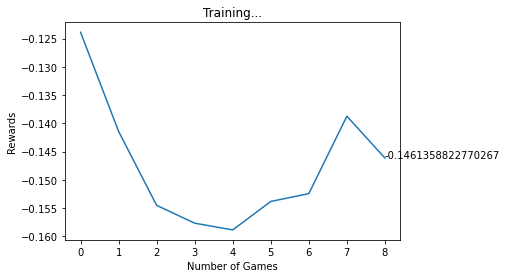

In [ ]:

while True:
    observation = env.reset()
    for t in range(maxIt):
        env.render()
        
        action = mccAgent.getAction(observation)
        #print(action)
        next_observation, reward, done, info = env.step(action)
        #Save to memory
        mccAgent.addToMemory(observation,action,reward)
        observation = next_observation
        if done:
            #print(next_observation, reward, done)
            print("Episode finished after {} timesteps".format(t+1))
            
            break
    mccAgent.trainFromEpisode()
    
    print(mccAgent.getMeanRewards())
    plot_mean_rewards.append(mccAgent.getMeanRewards())
    plot(plot_mean_rewards)
    mccAgent.clearMemory()
        

In [448]:
import matplotlib.pyplot as plt
from IPython import display

plt.ion()

def plot(mean_rewards):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Rewards')
    plt.plot(mean_rewards)
    plt.text(len(mean_rewards)-1, mean_rewards[-1], str(mean_rewards[-1]))
    plt.show(block=False)
    plt.pause(.1)